# Imports

In [66]:
import pandas as pd
import numpy as np
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


# Data pre-processing and preparation

### Obtaining the data

We used the following python script:

In [62]:
# python features.py

### Unifying the class labels with the data

In [63]:
df = pd.read_csv('urbansounds_features.csv')

In [64]:
df['Label'] = df['Label'].str.split('-').str[1]

# Display the first few rows of the updated DataFrame
print(df.head())

   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.494262    0.568759     0.267266       3.465249  0.068657  2177.483658   
1     0.422076    0.556903     0.270826       3.132792  0.076706  1623.980658   
2     0.575613    0.606710     0.275953       2.257988  0.044251  2615.200756   
3     0.175040    0.526637     0.258603       1.481219  0.043195  1223.789196   
4     0.412279    0.608818     0.264944       0.806509  0.035636  1470.863386   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  3649.518344  19.685466  0.002088  4745.917969  ... -2.700133 -0.350788   
1  2897.277104  21.508354  0.001123  2743.891814  ... -5.048006 -1.626652   
2  4200.855657  18.001559  0.003370  6143.329229  ... -1.015445  0.989107   
3  1367.391253  16.179755  0.583564  2473.821756  ...  2.447487 -1.956081   
4  2296.662162  12.349992  0.353831  3264.932914  ...  0.232175  0.326373   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

### Check for object values

In [65]:
object_columns = df.select_dtypes(include=['object']).columns
object_columns

Index(['fourier_tempogram', 'Label'], dtype='object')

### Convert the columns with object values to numeric

In [67]:
def calculate_mean_from_string(string):
    cleaned_string = string.replace('\n', '')
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", cleaned_string)
    array = np.array(numbers, dtype=float)
    mean_value = np.mean(array)
    return mean_value

In [68]:
df['Label'] = df['Label'].astype('int64')

In [69]:
df['fourier_tempogram'] = df['fourier_tempogram'].apply(calculate_mean_from_string)

In [71]:
df

,chroma_stft,chroma_cqt,chroma_cens,melspectogram,rms,centroid,bandwidth,contrast,flatness,rolloff,...,mcffs_32,mcffs_33,mcffs_34,mcffs_35,mcffs_36,mcffs_37,mcffs_38,mcffs_39,mcffs_40,Label
0,0.494262,0.568759,0.267266,3.465249,0.068657,2177.483658,3649.518344,19.685466,0.002088,4745.917969,...,-2.700133,-0.350788,-0.123943,-0.308717,0.377525,-0.907509,-0.254973,-1.738416,-1.207377,3
1,0.422076,0.556903,0.270826,3.132792,0.076706,1623.980658,2897.277104,21.508354,0.001123,2743.891814,...,-5.048006,-1.626652,-1.303208,-1.028367,0.470883,-2.959822,-1.439514,-2.282194,-1.155120,3
2,0.575613,0.606710,0.275953,2.257988,0.044251,2615.200756,4200.855657,18.001559,0.003370,6143.329229,...,-1.015445,0.989107,1.142546,0.407650,-0.166601,-0.859933,-0.637618,-1.657652,-1.639226,3
3,0.175040,0.526637,0.258603,1.481219,0.043195,1223.789196,1367.391253,16.179755,0.583564,2473.821756,...,2.447487,-1.956081,0.440909,-1.384400,0.585570,-0.601787,-0.864582,-0.896903,-0.161344,3
4,0.412279,0.608818,0.264944,0.806509,0.035636,1470.863386,2296.662162,12.349992,0.353831,3264.932914,...,0.232175,0.326373,0.610677,0.570734,1.030308,0.507107,0.160745,0.642600,0.364088,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,0.479371,0.552483,0.266297,2.410669,0.127638,2431.943128,2504.586835,16.611774,0.000412,4677.947945,...,0.199730,-0.839973,-4.665137,-0.551395,0.214190,0.865874,1.078110,-3.648149,0.705190,2
8728,0.545358,0.593931,0.273223,2.837043,0.130824,1979.367181,2215.734460,16.131903,0.000247,3817.306386,...,0.332412,2.602965,-0.238956,2.640356,-0.004591,-0.695137,-0.639137,-2.883146,0.214829,2
8729,0.436206,0.605989,0.275923,5.695730,0.190655,2192.398026,2140.849300,17.080651,0.000198,4041.189283,...,0.285693,1.105075,-2.979676,0.069636,0.038741,0.715938,2.593126,-2.714100,1.224722,2
8730,0.524807,0.671077,0.277764,3.745609,0.153592,2187.172172,2190.171430,16.642445,0.000244,4042.500000,...,-0.099813,0.535876,-0.444768,2.225560,1.202731,-1.514751,1.340369,-0.692652,1.283734,2


### Check interval of the values per column

In [72]:
column_intervals = df.describe().loc[['min', 'max']]
column_intervals

,chroma_stft,chroma_cqt,chroma_cens,melspectogram,rms,centroid,bandwidth,contrast,flatness,rolloff,...,mcffs_32,mcffs_33,mcffs_34,mcffs_35,mcffs_36,mcffs_37,mcffs_38,mcffs_39,mcffs_40,Label
min,0.008760,0.118011,0.126660,0.017318,0.001788,49.252793,66.012024,3.938343,1.648695e-07,81.951002,...,-12.144473,-19.343061,-28.116508,-16.987791,-14.576315,-36.001620,-23.080887,-25.212177,-13.395362,0.0
max,0.845297,0.796146,0.286841,65.208150,0.579545,10907.707763,7532.173550,29.609336,9.798845e-01,18628.717306,...,19.055628,15.425904,22.999128,20.503590,26.710932,23.912758,17.683758,17.977505,30.761436,9.0


### Check the distribution of the classes

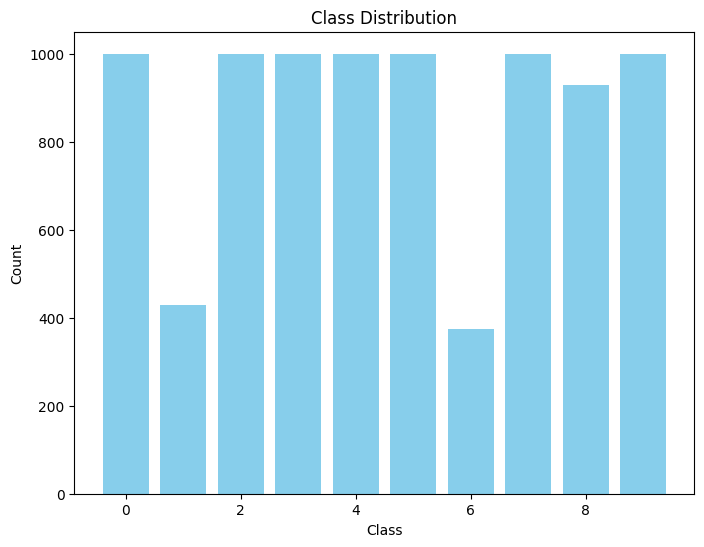

In [74]:
class_counts = df['Label'].value_counts()
class_labels = class_counts.index
class_values = class_counts.values

plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

### The classes are not balanced nor normalized, so we will need adress that in the training set

In [ ]:
X = df.drop('Label', axis=1) 
y = df['Label']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Oversample the features values using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Show a graph of the class distribution
class_counts = y_train_resampled.value_counts()
class_labels = class_counts.index
class_values = class_counts.values

plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Standardize the feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Model architecture definition

The classifiers we chose were the following: a classifier based on multilayer perceptron (MLP) and a convolutional neural network (CNN).

### MLP classifier

For the MLP classifier, we need to define the following parameters: number of layers, number of neurons
per layer and the activation function for each layer.

# Training strategy

Optimizer
Learning hyperparameters
Regularization techniques
Possibility of using transfer learning

Choosing the best optimizer involves expererimenting and comparing the results of different optimizers to see what works best. We tested the following: SGD, Adam, and Adagrad.
A traditional default value for the learning rate is 0.1 or 0.01. We chose 0.05 as a learning rate for our MLP classifier.
Batch size - ??
Too few epochs may result in underfitting, while too many epochs may lead to overfitting, so we tried 300 and got good results.
We used early stopping to prevent overfitting and chose 0.1 as dropout rate.
 

## CNN classifier